In [1]:
from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [3]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((fft.real, fft.imag))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)


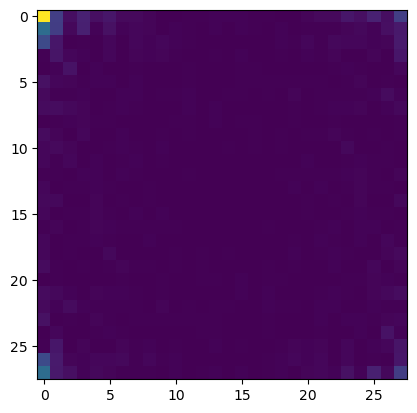

In [4]:
plt.imshow(np.abs(train_fft[0])[0])

In [5]:
class CustomTransform:
    def __call__(self, sample):
        real, imag = sample      
        # Stack the image and FFT side by side
        combined = np.concatenate([real, imag], axis=1)
        return torch.from_numpy(combined).float()

In [6]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample[None,:,:], label

In [7]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels) 

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [8]:
item = next(iter(train_loader))

In [15]:
model = ViT(
    image_size = 56,
    patch_size = 7,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 12,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 1
)

img = torch.randn(1, 1, 28, 56)

preds = model(img) # (1, 1000)

In [16]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6337132


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:


model.to(device)
epochs = 500
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 1: 100%|██████████| 938/938 [01:15<00:00, 12.45batch/s, Train Loss=0.517, Train Acc=81.6]


Epoch 1
Train Loss: 0.5166, Train Accuracy: 81.59%
Test Loss: 0.3587, Test Accuracy: 86.95%



Epoch 2: 100%|██████████| 938/938 [01:15<00:00, 12.40batch/s, Train Loss=0.33, Train Acc=88]   


Epoch 2
Train Loss: 0.3304, Train Accuracy: 87.96%
Test Loss: 0.3338, Test Accuracy: 88.03%



Epoch 3: 100%|██████████| 938/938 [01:15<00:00, 12.39batch/s, Train Loss=0.287, Train Acc=89.5]


Epoch 3
Train Loss: 0.2867, Train Accuracy: 89.48%
Test Loss: 0.3272, Test Accuracy: 88.51%



Epoch 4: 100%|██████████| 938/938 [01:16<00:00, 12.34batch/s, Train Loss=0.257, Train Acc=90.5]


Epoch 4
Train Loss: 0.2566, Train Accuracy: 90.47%
Test Loss: 0.3037, Test Accuracy: 89.01%



Epoch 5: 100%|██████████| 938/938 [01:15<00:00, 12.39batch/s, Train Loss=0.227, Train Acc=91.6]


Epoch 5
Train Loss: 0.2267, Train Accuracy: 91.59%
Test Loss: 0.3142, Test Accuracy: 89.13%



Epoch 6: 100%|██████████| 938/938 [01:15<00:00, 12.41batch/s, Train Loss=0.202, Train Acc=92.6]


Epoch 6
Train Loss: 0.2019, Train Accuracy: 92.57%
Test Loss: 0.3200, Test Accuracy: 89.00%



Epoch 7:  80%|████████  | 752/938 [01:00<00:15, 12.40batch/s, Train Loss=0.178, Train Acc=93.4]


KeyboardInterrupt: 